Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [2]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [3]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,...,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,...,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,...,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,...,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,...,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [5]:
# Instead, predict property sales prices for One Family Dwellings 
# (BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS') using a subset 
# of the data where the sale price was more than $100 thousand and less than $2 million.

df = df[df.BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS']
df = df[(df.SALE_PRICE > 100000) & (df.SALE_PRICE < 2000000)]

In [15]:
#  making sure the last cell worked properly
print(df.BUILDING_CLASS_CATEGORY.value_counts())
print(df.SALE_PRICE.describe())

01 ONE FAMILY DWELLINGS    3151
Name: BUILDING_CLASS_CATEGORY, dtype: int64
count    3.151000e+03
mean     6.285601e+05
std      2.929904e+05
min      1.040000e+05
25%      4.475000e+05
50%      5.680000e+05
75%      7.600000e+05
max      1.955000e+06
Name: SALE_PRICE, dtype: float64


In [7]:
df.SALE_DATE = pd.to_datetime(df.SALE_DATE)

In [8]:
#making sure our column is in datetime
df.SALE_DATE.head()

44    2019-01-01
61    2019-01-01
78    2019-01-02
108   2019-01-02
111   2019-01-02
Name: SALE_DATE, dtype: datetime64[ns]

In [9]:
#just checking if how I want to make train/test sets will work
df.SALE_DATE.dt.year.value_counts()

2019    3151
Name: SALE_DATE, dtype: int64

In [10]:
df.SALE_DATE.dt.month.value_counts()

1    947
3    799
2    761
4    644
Name: SALE_DATE, dtype: int64

In [11]:
train = df[df.SALE_DATE.dt.month < 4 ]
print(train.SALE_DATE.dt.month.value_counts())
train.head()

1    947
3    799
2    761
Name: SALE_DATE, dtype: int64


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,...,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,...,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,...,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,...,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,...,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [12]:
test = df[df.SALE_DATE.dt.month == 4]
print(test.SALE_DATE.dt.month.value_counts())
test.head()

4    644
Name: SALE_DATE, dtype: int64


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18235,2,RIVERDALE,01 ONE FAMILY DWELLINGS,1,5913,878,NaN,A1,4616 INDEPENDENCE AVENUE,NaN,...,1.0,0.0,1.0,"5,000",2272.0,1930.0,1,A1,895000,2019-04-01
18239,2,THROGS NECK,01 ONE FAMILY DWELLINGS,1,5488,48,NaN,A2,558 ELLSWORTH AVENUE,NaN,...,1.0,0.0,1.0,"2,500",720.0,1935.0,1,A2,253500,2019-04-01
18244,3,BAY RIDGE,01 ONE FAMILY DWELLINGS,1,5936,31,NaN,A1,16 BAY RIDGE PARKWAY,NaN,...,1.0,0.0,1.0,"2,880",2210.0,1925.0,1,A1,1300000,2019-04-01
18280,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7813,24,NaN,A5,1247 EAST 40TH STREET,NaN,...,1.0,0.0,1.0,"1,305",1520.0,1915.0,1,A5,789000,2019-04-01
18285,3,GERRITSEN BEACH,01 ONE FAMILY DWELLINGS,1,8831,160,NaN,A9,2314 PLUMB 2ND STREET,NaN,...,1.0,0.0,1.0,"1,800",840.0,1925.0,1,A9,525000,2019-04-01


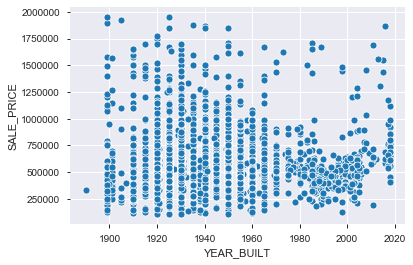

In [23]:
#train and test split finished. Time to work on some Seaborn visualizations
import seaborn as sns


sns.scatterplot(x='YEAR_BUILT', y='SALE_PRICE', data=train);

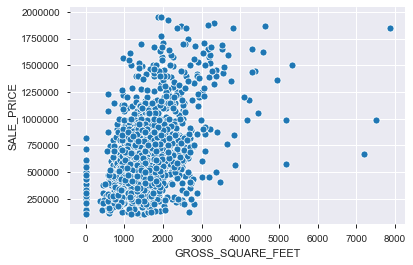

In [24]:
sns.scatterplot(x='GROSS_SQUARE_FEET', y='SALE_PRICE', data=train);

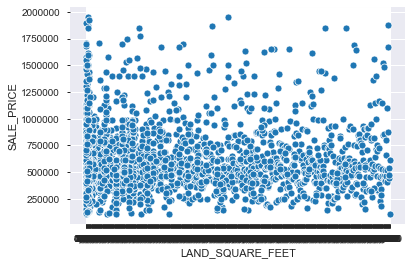

In [25]:
sns.scatterplot(x='LAND_SQUARE_FEET', y='SALE_PRICE', data=train);

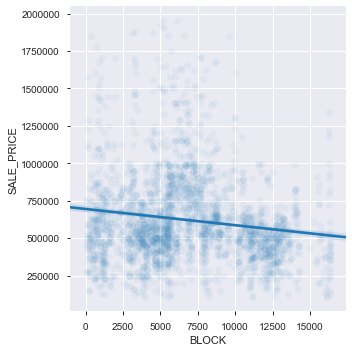

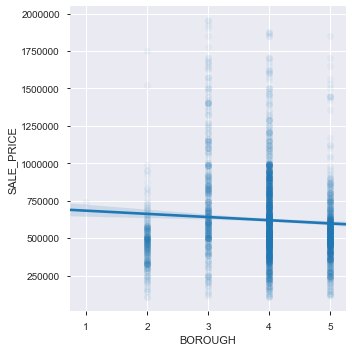

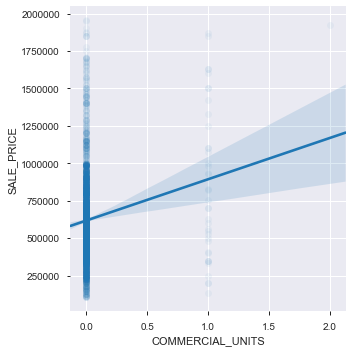

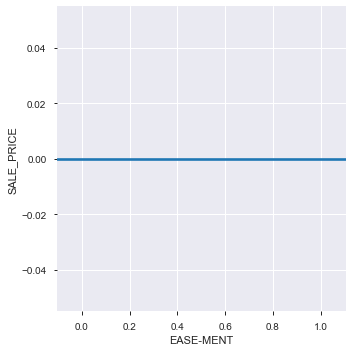

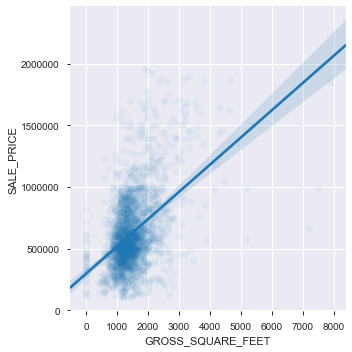

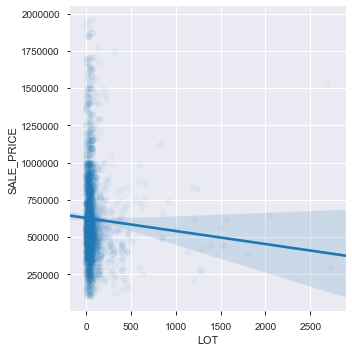

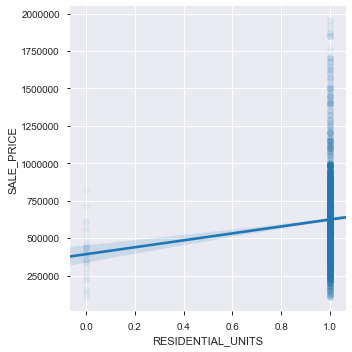

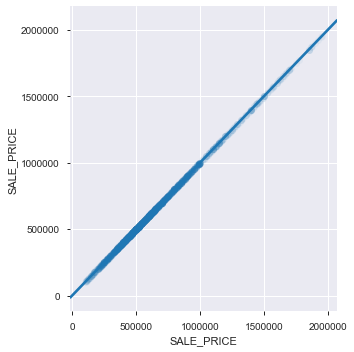

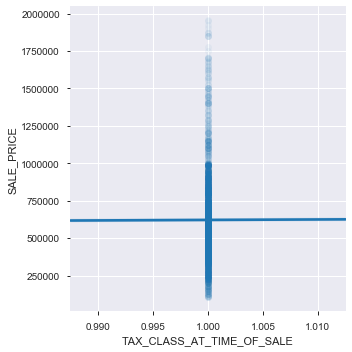

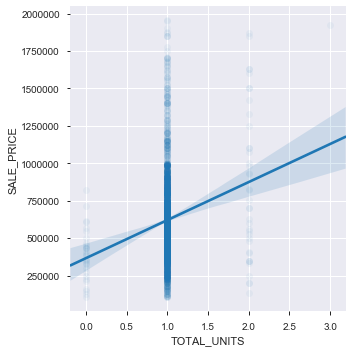

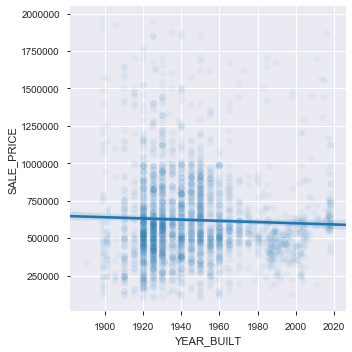

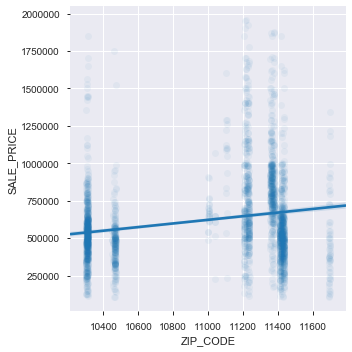

In [28]:
import matplotlib.pyplot as plt
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y = 'SALE_PRICE', data = train, scatter_kws = dict(alpha=0.05))
    plt.show()

In [32]:
#time for one-hot encoding. let's see which columns are non-numeric
train.describe(exclude='number')

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2507,2507,2507,2507,2507,1,2507,2507,2507
unique,176,1,2,13,2497,1,887,11,68
top,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,A1,294 FREEBORN STREET,RP.,"4,000",A1,2019-01-31 00:00:00
freq,77,2507,2476,919,2,1,234,919,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [33]:
# the neighborhoods are pretty much one-hot encoded in the borough column, building class is all the same 
# since we're only doing one family dwellings, address is in a similar situation with neighborhood, apartment
# number seems irrelevant, and sale date is in datetime format, which I like. 
# that leaves us with tax class, building class at present, land square feet(??) and building class at time of sale

In [55]:
train.TAX_CLASS_AT_PRESENT = train.TAX_CLASS_AT_PRESENT.replace('1', 1).replace('1D', 0)
train.TAX_CLASS_AT_PRESENT.value_counts()

C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


1    2476
0      31
Name: TAX_CLASS_AT_PRESENT, dtype: int64

In [56]:
test.TAX_CLASS_AT_PRESENT.value_counts()

1     635
1D      9
Name: TAX_CLASS_AT_PRESENT, dtype: int64

In [57]:
test.TAX_CLASS_AT_PRESENT = test.TAX_CLASS_AT_PRESENT.replace('1', 1).replace('1D', 0)
test.TAX_CLASS_AT_PRESENT.value_counts()

1    635
0      9
Name: TAX_CLASS_AT_PRESENT, dtype: int64

In [60]:
print(train.BUILDING_CLASS_AT_PRESENT.value_counts())
test.BUILDING_CLASS_AT_PRESENT.value_counts()

A1    919
A5    779
A2    411
A9    193
A0     67
S1     39
A3     38
A8     31
A6     14
A4     13
B2      1
S0      1
B3      1
Name: BUILDING_CLASS_AT_PRESENT, dtype: int64


A1    266
A5    206
A2     80
A9     46
A0     18
S1      9
A8      9
A3      5
A4      3
B2      1
A6      1
Name: BUILDING_CLASS_AT_PRESENT, dtype: int64

In [63]:
building_class = {'A1':0, 'A2':1, 'A3':2, 'A4':3, 'A5':4, 'A6':5, 'A8':6, 'A9':7, 'A0':8, 'B2':9, 'B3':10, 'S0':11, 'S1':12}
train.BUILDING_CLASS_AT_PRESENT.replace(building_class, inplace=True)
print(train.BUILDING_CLASS_AT_PRESENT.value_counts())
test.BUILDING_CLASS_AT_PRESENT.replace(building_class, inplace = True)
print(test.BUILDING_CLASS_AT_PRESENT.value_counts())

C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


0     919
4     779
1     411
7     193
8      67
12     39
2      38
6      31
5      14
3      13
11      1
9       1
10      1
Name: BUILDING_CLASS_AT_PRESENT, dtype: int64
0     266
4     206
1      80
7      46
8      18
12      9
6       9
2       5
3       3
9       1
5       1
Name: BUILDING_CLASS_AT_PRESENT, dtype: int64


In [64]:
train.BUILDING_CLASS_AT_TIME_OF_SALE.replace(building_class, inplace=True)
test.BUILDING_CLASS_AT_TIME_OF_SALE.replace(building_class, inplace=True)
print(train.BUILDING_CLASS_AT_TIME_OF_SALE.value_counts())
test.BUILDING_CLASS_AT_TIME_OF_SALE.value_counts()

0     919
4     779
1     413
7     193
8      67
12     39
2      38
6      31
5      14
3      13
11      1
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64


0     267
4     206
1      80
7      46
8      18
12      9
6       9
2       5
3       3
5       1
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

In [68]:
train.LAND_SQUARE_FEET.value_counts()

4,000     234
2,000     187
2,500     145
1,800      95
3,000      92
5,000      59
2,200      38
2,400      32
1,600      32
6,000      31
0          31
1,900      25
3,800      24
2,800      22
4,500      18
2,600      18
2,300      18
2,375      17
3,200      17
2,100      15
2,250      15
3,500      14
4,200      12
2,700      12
1,500      12
3,600      11
4,400      10
1,710      10
8,000       9
2,625       8
         ... 
2,635       1
4,480       1
3,504       1
3,999       1
3,228       1
2,776       1
1,986       1
2,408       1
2,024       1
3,527       1
2,603       1
2,626       1
2,323       1
780         1
3,167       1
3,915       1
4,218       1
1,400       1
1,092       1
2,771       1
1,655       1
5,390       1
2,540       1
3,052       1
5,533       1
4,116       1
10,575      1
4,160       1
4,057       1
7,124       1
Name: LAND_SQUARE_FEET, Length: 887, dtype: int64

In [69]:
#this one is already numeric. not sure why it wasn't excluded earlier

In [72]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset  = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'SALE_PRICE'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test  = test_subset[features]
y_test  = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2507, 13), (2507,), (644, 13), (644,))

In [73]:
# on to feature selection
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k = 10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((2507, 10), (644, 10))

In [74]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

Features selected:
BOROUGH
TAX_CLASS_AT_PRESENT
BLOCK
LOT
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
YEAR_BUILT


In [75]:
#on to linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')

Test MAE: $167,663


In [76]:
import statsmodels.api as sm
X1 = sm.add_constant(X_train_selected)
result = sm.OLS(y_train, X1).fit()
print(result.rsquared, result.rsquared_adj)


0.3716947860664994 0.3696825996327653


In [81]:
for k in range(1, len(X_train.columns)+1):
  print(f'{k} features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f}\n')

1 features
Test MAE: $183,641

2 features
Test MAE: $184,003

3 features
Test MAE: $183,943

4 features
Test MAE: $167,050

5 features
Test MAE: $167,908

6 features
Test MAE: $167,908

7 features
Test MAE: $167,772

8 features
Test MAE: $168,000

9 features
Test MAE: $167,997

10 features
Test MAE: $167,663

11 features
Test MAE: $167,791

12 features
Test MAE: $167,372

13 features
Test MAE: $167,372



C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\sklearn\fe

In [82]:
# so we want to use 4 features, since that gives us the lowest MAE.
selector = SelectKBest(score_func=f_regression, k=4)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)

mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}\n')

Test MAE: $167,050



C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\redfo\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [83]:
# and we can also get an r^2 and r^2 adjusted score
import statsmodels.api as sm
X1 = sm.add_constant(X_train_selected)
result = sm.OLS(y_train, X1).fit()
print(result.rsquared, result.rsquared_adj)


0.36386878297766667 0.36285178662751116


In [13]:
# Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
#  Do exploratory visualizations with Seaborn.
#  Do one-hot encoding of categorical features.
#  Do feature selection with SelectKBest.
#  Fit a linear regression model with multiple features.
#  Get mean absolute error for the test set.
#  As always, commit your notebook to your fork of the GitHub repo.